🧪 Testing EfficientNet Model
Using device: cuda
Dataset initialized with 25596 images
Test dataset loaded with 25596 images


/data1/home/prakrutp/miniconda3/envs/med_env_fixed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_228810/2002151496.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

Loading model from: checkpoints_efficientnet/best_model.pth
Model was trained for 100 epochs
Best validation AUC: 0.8239
Evaluating model on test dataset...


Testing: 100%|██████████| 1600/1600 [02:05<00:00, 12.72it/s]



COMPREHENSIVE MODEL EVALUATION

AUC Scores per class:
----------------------------------------
Atelectasis         : 0.7409
Cardiomegaly        : 0.8875
Effusion            : 0.8159
Infiltration        : 0.6991
Mass                : 0.7928
Nodule              : 0.7330
Pneumonia           : 0.6845
Pneumothorax        : 0.8482
Consolidation       : 0.7286
Edema               : 0.8329
Emphysema           : 0.9218
Fibrosis            : 0.7819
Pleural_Thickening  : 0.7603
Hernia              : 0.8955

Mean AUC: 0.7945

Detailed Classification Report:
--------------------------------------------------
Atelectasis         : Precision: 0.5020, Recall: 0.0384, F1: 0.0714
Cardiomegaly        : Precision: 0.5180, Recall: 0.1478, F1: 0.2300
Effusion            : Precision: 0.4980, Recall: 0.4620, F1: 0.4793
Infiltration        : Precision: 0.4569, Recall: 0.1821, F1: 0.2604
Mass                : Precision: 0.4265, Recall: 0.2357, F1: 0.3036
Nodule              : Precision: 0.3680, Recall: 0.0764,

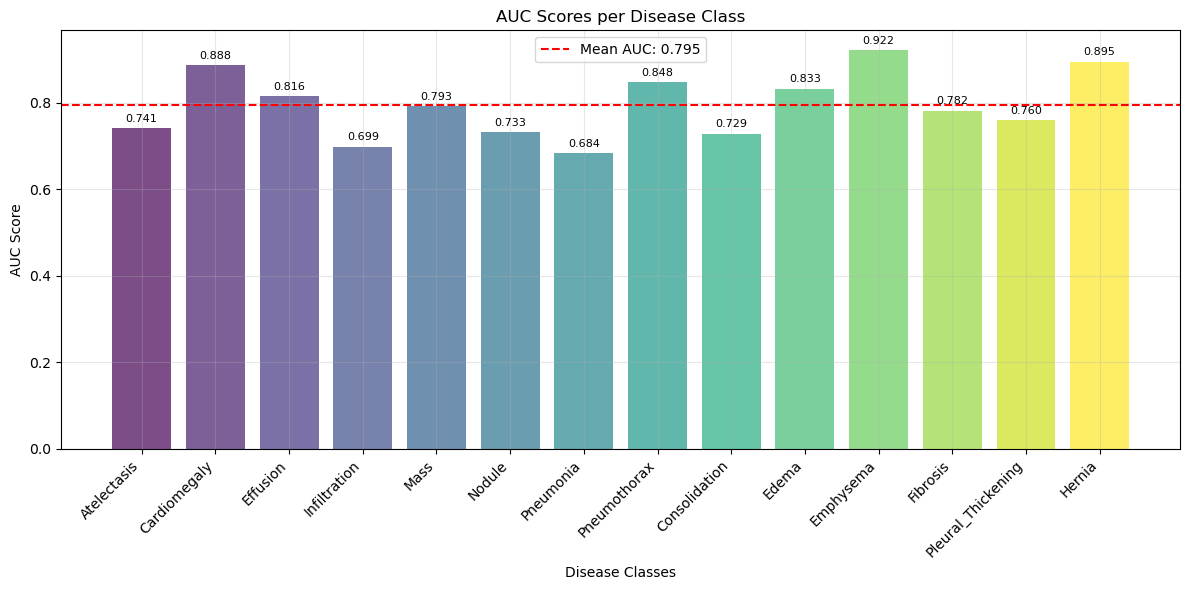

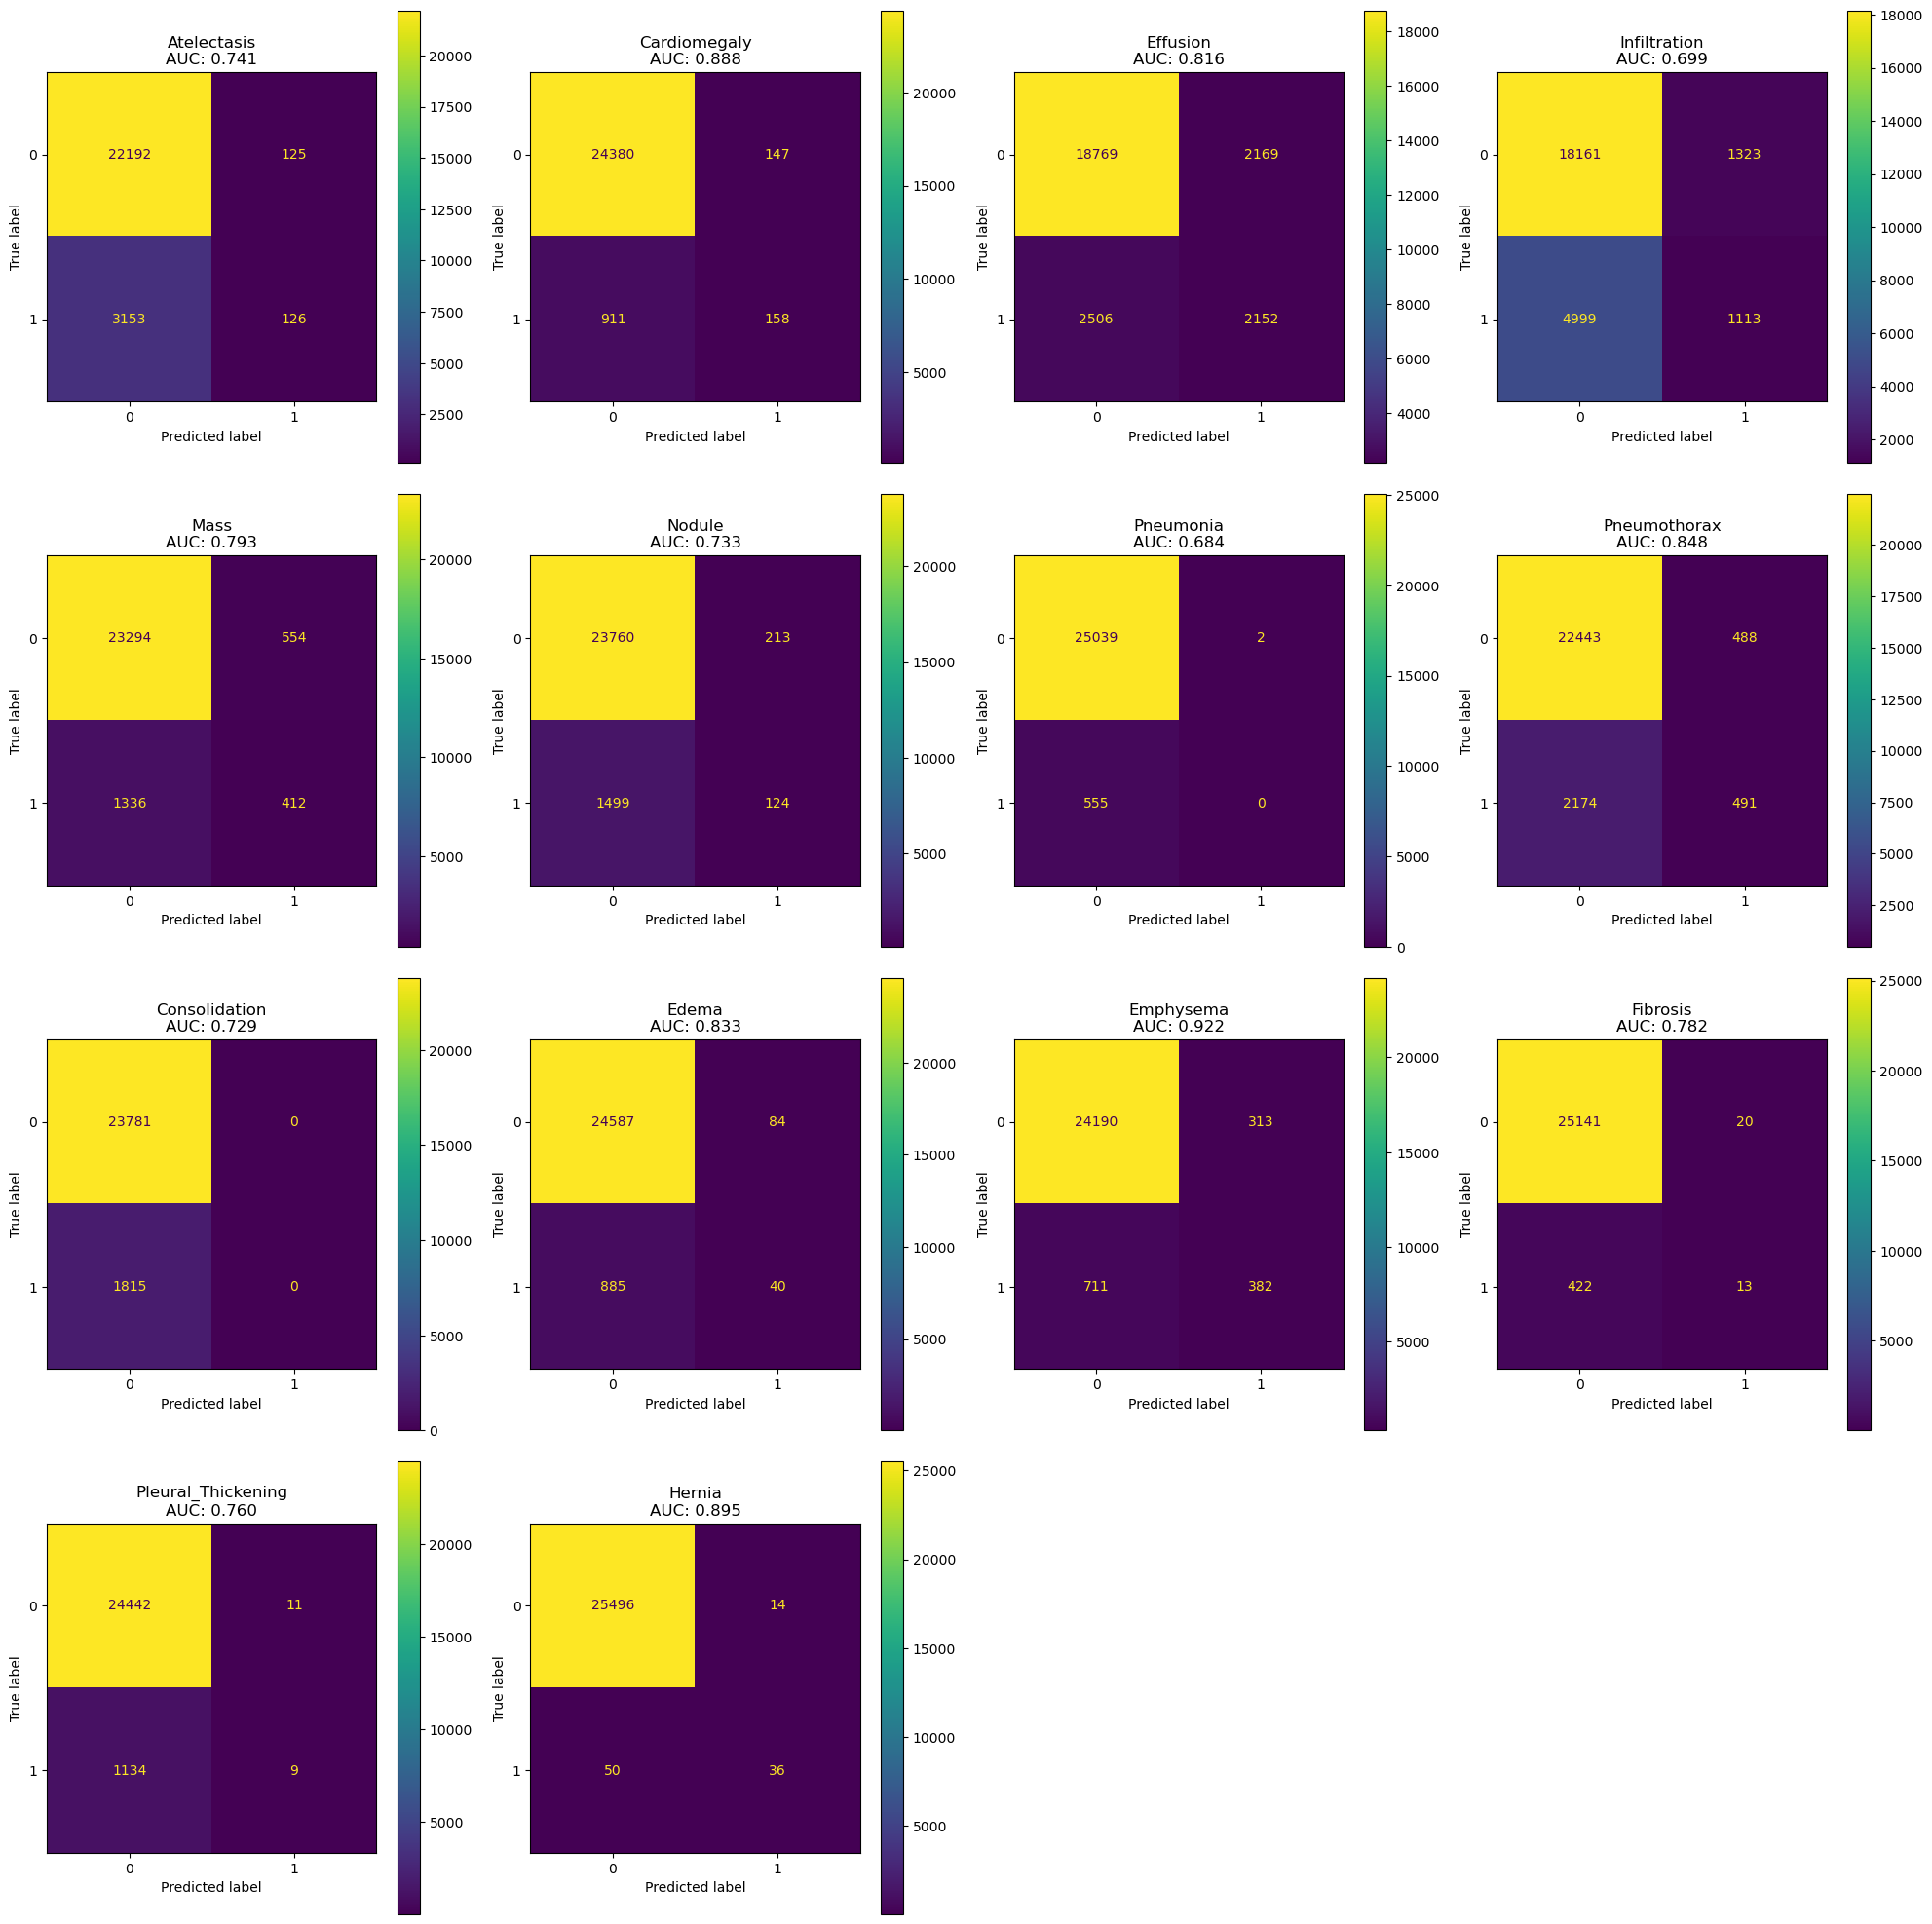


Results saved with timestamp: 20251122_174847

✅ Testing completed successfully!
📊 Final Test AUC: 0.7945


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import json
from datetime import datetime

# Use the same Config class from your training script
class Config:
    data_dir = "/data1/home/prakrutp/medical_imaging/dataset"
    csv_path = "/data1/home/prakrutp/medical_imaging/dataset/Data_Entry_2017.csv"
    image_size = 512
    batch_size = 16
    num_classes = 14
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = "tf_efficientnet_b3"
    feature_dim = 1536
    test_list_file = "test_list.txt"
    train_val_list_file = "train_val_list.txt"
    checkpoint_dir = "checkpoints_efficientnet"

# Import your dataset class (make sure it's available)
class ChestXrayDataset:
    # Use the same ChestXrayDataset class from your training script
    def __init__(self, csv_file, base_dir, image_list=None, transform=None):
        self.df = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.transform = transform
        
        self.disease_classes = [
            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
            'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
            'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
            'Pleural_Thickening', 'Hernia'
        ]
        
        self._create_label_columns()
        
        if image_list is not None:
            self.data_frame = self.df[self.df['Image Index'].isin(image_list)].reset_index(drop=True)
        else:
            self.data_frame = self.df
        
        print(f"Dataset initialized with {len(self.data_frame)} images")
        
    def _create_label_columns(self):
        for disease in self.disease_classes:
            self.df.loc[:, disease] = self.df['Finding Labels'].apply(
                lambda x: 1 if disease in x else 0
            )
    
    def _find_image_path(self, img_name):
        for i in range(1, 13):
            folder_name = f"images_{i:03d}"
            possible_path = os.path.join(self.base_dir, folder_name, "images", img_name)
            if os.path.exists(possible_path):
                return possible_path
        return os.path.join(self.base_dir, "images_001", "images", img_name)
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]['Image Index']
        img_path = self._find_image_path(img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Could not load image {img_path}: {e}")
            image = Image.new('RGB', (Config.image_size, Config.image_size), color='black')
        
        labels = []
        for disease in self.disease_classes:
            labels.append(self.data_frame.iloc[idx][disease])
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.FloatTensor(labels)

# Import your model class
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=14, model_name="tf_efficientnet_b3"):
        super(EfficientNetModel, self).__init__()
        import timm
        
        self.backbone = timm.create_model(
            model_name, 
            pretrained=False,  # We'll load trained weights
            num_classes=0
        )
        
        if "b3" in model_name:
            self.feature_dim = 1536
        else:
            self.feature_dim = self.backbone.num_features
        
        self.classifier = nn.Linear(self.feature_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        output = self.sigmoid(output)
        return output

def load_split_file(file_path):
    """Load image list from split file"""
    with open(file_path, 'r') as f:
        image_names = [line.strip() for line in f.readlines()]
    return image_names

def load_test_dataset():
    """Load test dataset with proper transforms"""
    test_transform = transforms.Compose([
        transforms.Resize((Config.image_size, Config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    test_list_path = os.path.join(Config.data_dir, Config.test_list_file)
    test_images = load_split_file(test_list_path)
    
    test_dataset = ChestXrayDataset(
        csv_file=Config.csv_path,
        base_dir=Config.data_dir,
        image_list=test_images,
        transform=test_transform
    )
    
    print(f"Test dataset loaded with {len(test_dataset)} images")
    return test_dataset

def load_best_model(model, checkpoint_path=None):
    """Load the best model from checkpoint"""
    if checkpoint_path is None:
        # Look for best model
        best_model_path = os.path.join(Config.checkpoint_dir, "best_model.pth")
        if os.path.exists(best_model_path):
            checkpoint_path = best_model_path
        else:
            # Look for latest checkpoint
            checkpoint_files = [f for f in os.listdir(Config.checkpoint_dir) 
                              if f.startswith('checkpoint_epoch_')]
            if not checkpoint_files:
                raise FileNotFoundError("No checkpoints found!")
            epochs = [int(f.split('_')[2].split('.')[0]) for f in checkpoint_files]
            latest_epoch = max(epochs)
            checkpoint_path = os.path.join(Config.checkpoint_dir, 
                                         f"checkpoint_epoch_{latest_epoch:03d}.pth")
    
    print(f"Loading model from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=Config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if 'best_auc' in checkpoint:
        print(f"Model was trained for {checkpoint['epoch']} epochs")
        print(f"Best validation AUC: {checkpoint['best_auc']:.4f}")
    
    return model

def evaluate_model(model, test_loader):
    """Evaluate model on test dataset"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print("Evaluating model on test dataset...")
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(Config.device)
            labels = labels.to(Config.device)
            
            outputs = model(inputs)
            probabilities = outputs.cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)
            
            all_probabilities.append(probabilities)
            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate all batches
    all_probabilities = np.concatenate(all_probabilities)
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    
    return all_probabilities, all_predictions, all_labels

def calculate_metrics(probabilities, predictions, labels, disease_classes):
    """Calculate comprehensive evaluation metrics"""
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    metrics = {}
    
    # Calculate AUC for each class
    auc_scores = []
    print("\nAUC Scores per class:")
    print("-" * 40)
    
    for i, disease in enumerate(disease_classes):
        try:
            if np.sum(labels[:, i]) > 0:  # Only calculate if class exists in test set
                auc = roc_auc_score(labels[:, i], probabilities[:, i])
                auc_scores.append(auc)
                print(f"{disease:<20}: {auc:.4f}")
            else:
                auc_scores.append(0.0)
                print(f"{disease:<20}: No positive samples")
        except Exception as e:
            auc_scores.append(0.0)
            print(f"{disease:<20}: Error calculating AUC")
    
    metrics['auc_scores'] = auc_scores
    metrics['mean_auc'] = np.mean([auc for auc in auc_scores if auc > 0])
    
    print(f"\nMean AUC: {metrics['mean_auc']:.4f}")
    
    # Calculate precision, recall, f1-score for each class
    print("\nDetailed Classification Report:")
    print("-" * 50)
    
    for i, disease in enumerate(disease_classes):
        if np.sum(labels[:, i]) > 0:  # Only calculate if class exists
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels[:, i], predictions[:, i], average='binary', zero_division=0
            )
            print(f"{disease:<20}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    # Overall metrics
    print("\nOverall Metrics:")
    print("-" * 20)
    
    # Accuracy
    accuracy = np.mean(predictions == labels)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Sample-based metrics
    sample_accuracy = np.mean(np.all(predictions == labels, axis=1))
    print(f"Exact Match Ratio: {sample_accuracy:.4f}")
    
    # Hamming loss
    hamming_loss = np.mean(predictions != labels)
    print(f"Hamming Loss: {hamming_loss:.4f}")
    
    metrics['accuracy'] = accuracy
    metrics['sample_accuracy'] = sample_accuracy
    metrics['hamming_loss'] = hamming_loss
    
    return metrics

def plot_confusion_matrix_per_class(probabilities, predictions, labels, disease_classes, threshold=0.5):
    """Plot confusion matrices for each class"""
    n_classes = len(disease_classes)
    n_cols = 4
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()
    
    for i, disease in enumerate(disease_classes):
        if i < len(axes):
            from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
            
            cm = confusion_matrix(labels[:, i], predictions[:, i])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(ax=axes[i], values_format='d')
            axes[i].set_title(f'{disease}\nAUC: {roc_auc_score(labels[:, i], probabilities[:, i]):.3f}')
    
    # Hide empty subplots
    for i in range(n_classes, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_per_class.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_auc_scores(auc_scores, disease_classes):
    """Plot AUC scores for each class"""
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(auc_scores)))
    
    bars = plt.bar(range(len(auc_scores)), auc_scores, color=colors, alpha=0.7)
    plt.axhline(y=np.mean(auc_scores), color='red', linestyle='--', 
                label=f'Mean AUC: {np.mean(auc_scores):.3f}')
    
    plt.xlabel('Disease Classes')
    plt.ylabel('AUC Score')
    plt.title('AUC Scores per Disease Class')
    plt.xticks(range(len(auc_scores)), disease_classes, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, auc in zip(bars, auc_scores):
        if auc > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{auc:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('auc_scores_per_class.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_results(metrics, probabilities, predictions, labels, disease_classes):
    """Save results to files"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save metrics to JSON
    results = {
        'timestamp': timestamp,
        'metrics': metrics,
        'class_names': disease_classes,
        'dataset_size': len(labels)
    }
    
    with open(f'test_results_{timestamp}.json', 'w') as f:
        json.dump(results, f, indent=4)
    
    # Save predictions to CSV
    results_df = pd.DataFrame({
        'true_labels': [str(row) for row in labels],
        'predictions': [str(row) for row in predictions],
        'probabilities': [str(row) for row in probabilities]
    })
    
    results_df.to_csv(f'predictions_{timestamp}.csv', index=False)
    
    print(f"\nResults saved with timestamp: {timestamp}")

def main_test():
    """Main testing function"""
    print("Testing EfficientNet Model")
    print(f"Using device: {Config.device}")
    
    # Load test dataset
    test_dataset = load_test_dataset()
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.batch_size, 
        shuffle=False, 
        num_workers=4
    )
    
    # Initialize model
    model = EfficientNetModel(
        num_classes=Config.num_classes, 
        model_name=Config.model_name
    )
    model = model.to(Config.device)
    
    # Load trained weights
    model = load_best_model(model)
    
    # Evaluate model
    probabilities, predictions, labels = evaluate_model(model, test_loader)
    
    # Calculate metrics
    disease_classes = test_dataset.disease_classes
    metrics = calculate_metrics(probabilities, predictions, labels, disease_classes)
    
    # Create visualizations
    plot_auc_scores(metrics['auc_scores'], disease_classes)
    plot_confusion_matrix_per_class(probabilities, predictions, labels, disease_classes)
    
    # Save results
    save_results(metrics, probabilities, predictions, labels, disease_classes)
    
    print("\nTesting completed successfully!")
    print(f"Final Test AUC: {metrics['mean_auc']:.4f}")

if __name__ == "__main__":
    main_test()